In [1]:
import pickle
import time
from IPython.display import clear_output
import sys
import os
import copy

import pandas as pd
import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import Table
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import DeepEnsemble
import metrics

from models.SAINT import SAINT
from models.augmentations import embed_data_mask

In [2]:
data_dir = 'data/q_photo_z_train'
with open(f'{data_dir}/feature_lists/features_sdssdr16+all_deacls8tr_QSO+GALAXY_20201212143658.pkl', 'rb') as f:
    features_20 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl', 'rb') as f:
    features_35 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_deacls8tr_QSO+GALAXY_20201212135641.pkl', 'rb') as f:
    features_21 = pickle.load(f)
with open(f'{data_dir}/feature_lists/features_psdr2+all_deacls8tr_QSO+GALAXY_20201212142333.pkl', 'rb') as f:
    features_22 = pickle.load(f)
np.random.seed(2)
torch.manual_seed(2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
train_01 = pd.read_csv(f'{data_dir}/train_01.csv').iloc[:1000]
train_02 = pd.read_csv(f'{data_dir}/train_02.csv').iloc[:1000]

In [4]:
train_01.shape, train_02.shape

((1000, 68), (1000, 68))

In [5]:
t_01 = train_01[['RA', 'DEC', 'Z'] + features_35].dropna().reset_index()
X_01 = t_01[features_35].values.astype(float)
y_01 = t_01['Z'].values.astype(float)

t_02 = train_02[['RA', 'DEC', 'Z'] + features_35].dropna().reset_index()
X_02 = t_02[features_35].values.astype(float)
y_02 = t_02['Z'].values.astype(float)

In [6]:
t_01.shape, t_02.shape

((962, 69), (952, 69))

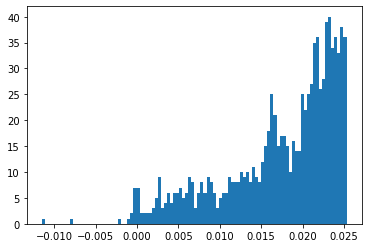

In [7]:
def p_func(z):
    return 1 / (1 + np.exp(-4*(z-5)))
n_dup = 100
z_thr = 0.0015 #4.5

dataloader = DeepEnsemble.HZ_dataloader_new(
    torch.tensor(X_01, device=torch.device(device), dtype=torch.float),
    torch.tensor(y_01, device=torch.device(device), dtype=torch.float), 
    p_func, n_dup, z_thr=5, batch_size=2**13, shuffle=False, device=device
)
plt.hist(y_01[dataloader.all_idx.cpu().numpy()], bins=100);

In [8]:
np.random.seed(1)
torch.manual_seed(1)

cat_dims = np.array([1])

ens = DeepEnsemble.DeepEnsemble_GMM(
    DeepEnsemble.MySAINT,
    {
        'cat_dims': cat_dims,
        'num_continuous': X_01.shape[1],
        'embedding_size': 16, 
        'transformer_depth': 3, 
        'attention_heads': 3,
        'attention_dropout': 0.0, 
        'ff_dropout': -.0, 
        'attentiontype': 'col',
        'enc_sizes': [16, 16, 1],
        'enc_dropout': 0.0,
    },
    5, device
)

X_cat_train_tensor = torch.tensor(np.zeros((X_01.shape[0], 1)), device=torch.device(device), dtype=torch.int)
X_con_train_tensor = torch.tensor(X_01, device=torch.device(device), dtype=torch.float)
y_train_tensor = torch.tensor(y_01, device=torch.device(device), dtype=torch.float)
X_cat_test_tensor = torch.tensor(np.zeros((X_02.shape[0], 1)), device=torch.device(device), dtype=torch.int)
X_con_test_tensor = torch.tensor(X_02, device=torch.device(device), dtype=torch.float)
y_test_tensor = torch.tensor(y_02, device=torch.device(device), dtype=torch.float)

optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

ens.fit(
    TrainDataloader=DeepEnsemble.HZ_dataloader_newCatCon,
    train_dataloader_params={
        'X_cat': X_cat_train_tensor, 'X_con': X_con_train_tensor, 'y': y_train_tensor,
        'p_func': p_func, 'n_dup': n_dup, 'z_thr': z_thr,
        'batch_size': 2**13, 'shuffle': True, 'device': device
    },
    TestDataloader=DeepEnsemble.SimpleDataloaderCatCon,
    test_dataloader_params={
        'X_cat': X_cat_test_tensor, 'X_con': X_con_test_tensor, 'y': y_test_tensor,
        'batch_size': 2**13, 'shuffle': True
    },
    epochs=3,#70, 
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={
        'S_nmad': metrics.sigma_nmad, 'out_rate': metrics.out_rate,
        # 'S_nmad_z4': metrics.sigma_nmad_z4, 'out_rate_z4': metrics.out_rate_z4,
        # 'S_nmad_z5': metrics.sigma_nmad_z5, 'out_rate_z5': metrics.out_rate_z5,
        # 'S_nmad_z6': sigma_nmad_z6, 'out_rate_z6': out_rate_z6,
    }
);

NameError: name 'DeepEnsemble' is not defined